In [1]:
import import_ipynb

from keras.layers import Input, Dense, Dropout, Concatenate, GlobalAveragePooling1D
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from IPython.display import display, Image, HTML, update_display
from models import create_uai_model
from keras.regularizers import L1L2
from threading import Thread, Lock
from keras.models import Model
import keras_tuner as kt
import tensorflow as tf
import numpy as np
import warnings
import datetime
import dataset
import tools
import users
import time
import ads
import os

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [2]:
root_directories = ["ADS16_Benchmark_part1", "ADS16_Benchmark_part2"]

In [3]:
def load_user_and_ad_ftrs(root_directories, try_load_files=True, save_files=True):
    ad_ftrs_path = os.path.join("data", "ad_ftrs.npz")
    user_ftrs_and_ratings_path = os.path.join("data", "user_ftrs_and_ratings.npz")

    if try_load_files and os.path.exists(ad_ftrs_path):
        with np.load(ad_ftrs_path) as ad_ftrs_file:
            ad_ftrs = (ad_ftrs_file["ftrs1"], ad_ftrs_file["ftrs2"])
            num_categories = int(ad_ftrs_file["num_categories"])
    else:
        ad_ftrs, num_categories = ads.load_ftrs(root_directories)
        if save_files:
            np.savez(ad_ftrs_path, ftrs1=ad_ftrs[0], ftrs2=ad_ftrs[1], num_categories=num_categories)
    
    if try_load_files and os.path.exists(user_ftrs_and_ratings_path):
        with np.load(user_ftrs_and_ratings_path) as user_ftrs_and_ratings:
            user_ftrs = user_ftrs_and_ratings["user_ftrs"]
            ratings = user_ftrs_and_ratings["ratings"]
    else:
        raw_user_ftrs, ratings = users.load_raw_ftrs(root_directories)
        *_, user_ftrs = users.calculate_pca_ftrs(raw_user_ftrs)
        if save_files:
            np.savez(user_ftrs_and_ratings_path, user_ftrs=user_ftrs, ratings=ratings)
    
    return ad_ftrs, num_categories, user_ftrs, ratings

if __name__ == "__main__":
    ad_ftrs, num_categories, user_ftrs, ratings = load_user_and_ad_ftrs(root_directories)

In [ ]:
def create_model(hp=None):
    ad_ftrs, _, user_ftrs, ratings = load_user_and_ad_ftrs(root_directories)
    return create_uai_model(ad_ftrs, user_ftrs, ratings, hp=hp)

In [4]:
if __name__ == "__main__":
    X = tools.get_user_ad_ftr_product(user_ftrs, ad_ftrs)
    Y = tools.to_one_hot(ratings.flatten(), 1, 5)
    
    test_split = 0.2
    train_num = int((1-test_split) * X[0].shape[0])
    X_train, X_test = tools.split_all(X, train_num)
    Y_train, Y_test = Y[:train_num], Y[train_num:]


In [5]:
def plot_distributions(model, title):
    rows = num_categories + 1
    cols = 3

    fig = plt.figure(constrained_layout=True, figsize=(cols*8, rows*6))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        fig.suptitle(title, fontsize=20)
        fig.patch.set_facecolor("white")
        
        subfigs = fig.subfigures(rows, 1)

        pred = tools.from_one_hot(model.predict(X), 1, 5, mix=False).numpy()

        user_ftr_params = users.approximate_normal_params(user_ftrs.T)
        sim_user_ftrs = users.generate_synthetic_pca_ftrs(user_ftrs.shape[0], user_ftr_params)
        
        sim_pred = tools.from_one_hot(model.predict(get_user_ad_ftr_product(sim_user_ftrs, ad_ftrs)), 1, 5, mix=False).numpy()

        subfig = subfigs[0]
        subfig.suptitle("Overall Distributions")
        axs = subfig.subplots(1,3)
        
        pred_t = pred
        sim_pred_t = sim_pred
        # pred_t = np.clip(pred, 1, 5)
        # sim_pred_t = np.clip(sim_pred, 1, 5).astype(int)
        pred_t = np.round(pred_t).astype(int)
        sim_pred_t = np.round(sim_pred_t).astype(int)

        real_options = np.arange(1,6)
        pred_options = np.arange(min(real_options[0], np.min(pred_t)), max(real_options[-1], np.max(pred_t))+1)
        sim_pred_options = np.arange(min(real_options[0], np.min(sim_pred_t)), max(real_options[-1], np.max(sim_pred_t))+1)

        real_sizes = np.array([np.sum(ratings == i) for i in real_options])
        pred_sizes = np.array([np.sum(pred_t == i) for i in pred_options])
        sim_pred_sizes = np.array([np.sum(sim_pred_t == i) for i in sim_pred_options])

        i = 0
        axs[i].set_title("Ground Truth")
        axs[i].pie(real_sizes, labels=real_options, autopct='%1.1f%%', counterclock=False, startangle=90, explode=[0.01]*len(real_sizes))
        axs[i].legend()
        i += 1

        axs[i].set_title("Predicted (Real Users)")
        axs[i].pie(pred_sizes, labels=pred_options, autopct='%1.1f%%', counterclock=False, startangle=90, explode=[0.01]*len(pred_sizes))
        axs[i].legend()
        i += 1

        axs[i].set_title("Predicted (Simulated Users)")
        axs[i].pie(sim_pred_sizes, labels=sim_pred_options, autopct='%1.1f%%', counterclock=False, startangle=90, explode=[0.01]*len(sim_pred_sizes))
        axs[i].legend()
        i += 1


        for cat, subfig in enumerate(subfigs[1:]):
            subfig.suptitle(f"Category {cat}", fontsize=16)

            axs = subfig.subplots(1, cols)

            for col, ax in enumerate(axs):
                ax.plot()
                ax.set_xlabel(f"Rating")
                ax.set_ylabel(f"Probability Density")
                ax.xaxis.set_major_locator(MaxNLocator(integer=True))

            cat_mask = ad_ftrs[0][:,cat] == 1
            real_cat_ratings = ratings[:,cat_mask]
            pred_cat_ratings = pred.reshape(ratings.shape)[:,cat_mask]
            sim_cat_ratings = sim_pred.reshape(ratings.shape)[:,cat_mask]

            def get_bins(x):
                bins = np.arange(np.floor(min(np.min(x), np.min(real_cat_ratings))),np.ceil(max(np.max(x), np.max(real_cat_ratings)))+2,1) - 0.5
                bin_centers = 0.5*(bins[1:]+bins[:-1])
                return bins, bin_centers

            real_bins, real_bin_centers = get_bins(real_cat_ratings)
            pred_bins, pred_bin_centers = get_bins(pred_cat_ratings)
            sim_bins, sim_bin_centers = get_bins(sim_cat_ratings)

            i = 0

            axs[i].set_title(f"Ground Truth")
            for user in real_cat_ratings:
                heights, _ = np.histogram(user, bins=real_bins, density=True)
                axs[i].plot(real_bin_centers, heights, c="blue", alpha=0.1)
            i += 1
            
            axs[i].set_title(f"Predicted (Real Users)")
            for user in pred_cat_ratings:
                heights, _ = np.histogram(user, bins=pred_bins, density=True)
                axs[i].plot(pred_bin_centers, heights, c="red", alpha=0.1)
            i += 1
            
            axs[i].set_title(f"Predicted (Simulated Users)")
            for user in sim_cat_ratings:
                heights, _ = np.histogram(user, bins=sim_bins, density=True)
                axs[i].plot(sim_bin_centers, heights, c="green", alpha=0.1)
            i += 1
        
        plt.close()
    return fig

# if __name__ == "__main__":
#     display(plot_distributions(create_model(), "Rating Distributions"))


In [6]:
class DistributionPlotter(tools.DisplayableCallback):
    def __init__(self, **kwargs):
        super().__init__("Rating Distributions", **kwargs)
        self.lock = Lock()
        
    def on_epoch_end_(self, epoch, logs=None):
        with self.lock:
            self.update_display(plot_distributions(self.model, f"Rating Distributions: Epoch {epoch}"))

    def on_epoch_end(self, epoch, logs=None):
        if not self.lock.locked():
            Thread(target=self.on_epoch_end_, args=(epoch, logs)).start()
        return super().on_epoch_end(epoch, logs=logs)
    
    def plot_now(self):
        with self.lock:
            self.update_display(plot_distributions(self.model, f"Rating Distributions"))
            

if __name__ == "__main__":
    logs_dir="user_ad_interaction_model_logs"
    checkpoints_dir = os.path.join(logs_dir, "checkpoints")
    filepath = os.path.join(checkpoints_dir, "model-{epoch:06d}-{val_loss:06f}.hdf5")
    checkpoint = ModelCheckpoint(filepath, monitor=["val_loss"], save_weights_only=True, verbose=0, save_best_only=False, mode="min")

    log_dir = os.path.join(logs_dir, "fit", datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    

In [7]:
if __name__ == "__main__":

    tuner = tools.HyperbandWithBatchSize(
        create_model,
        objective=kt.Objective("val_rating_mae", direction="min"),
        max_epochs=100,
        factor=3,
        hyperband_iterations=5,
        directory=os.path.join(logs_dir, "hypertraining"),
        project_name="user_ad_interaction"
    )
    
    # print("EXAMPLE MODEL --- HYPERPARAMS NOT TUNED")
    # model = create_model()
    # model.summary()
    # c = tools.ModelDisplayer()
    # c.model = model
    # c.on_epoch_end(0)

    # c = DistributionPlotter()
    # c.model = model
    # c.plot_now()


INFO:tensorflow:Reloading Oracle from existing project user_ad_interaction_model_logs\hypertraining\user_ad_interaction\oracle.json
INFO:tensorflow:Reloading Tuner from user_ad_interaction_model_logs\hypertraining\user_ad_interaction\tuner0.json


Results summary
Results in user_ad_interaction_model_logs\hypertraining\user_ad_interaction
Showing 1 best trials
Trial summary
Hyperparameters:
input_dropout: 0.0
l1: 0.0001
l2: 0.0001
num_attn_heads: 6
ff_dim: 96
transformer_dropout_1: 0.0
transformer_dropout_2: 0.3
num_hidden_layers: 2
units_0: 96
dropout_0: 0.0
learning_rate: 0.001
batch_size: 64
units_1: 96
dropout_1: 0.0
units_2: 64
dropout_2: 0.1
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0203
Score: 0.2666666805744171


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 50, 25)]     0           []                               
                                                                                                  
 transformer_block (Transformer  (None, 50, 25)      2049

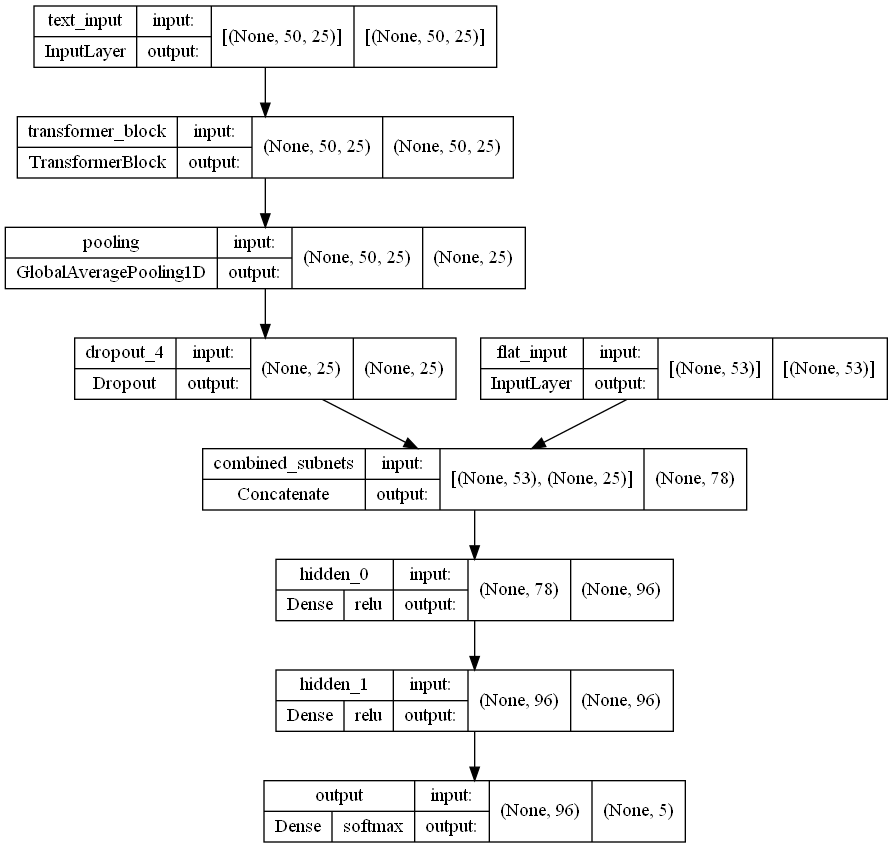

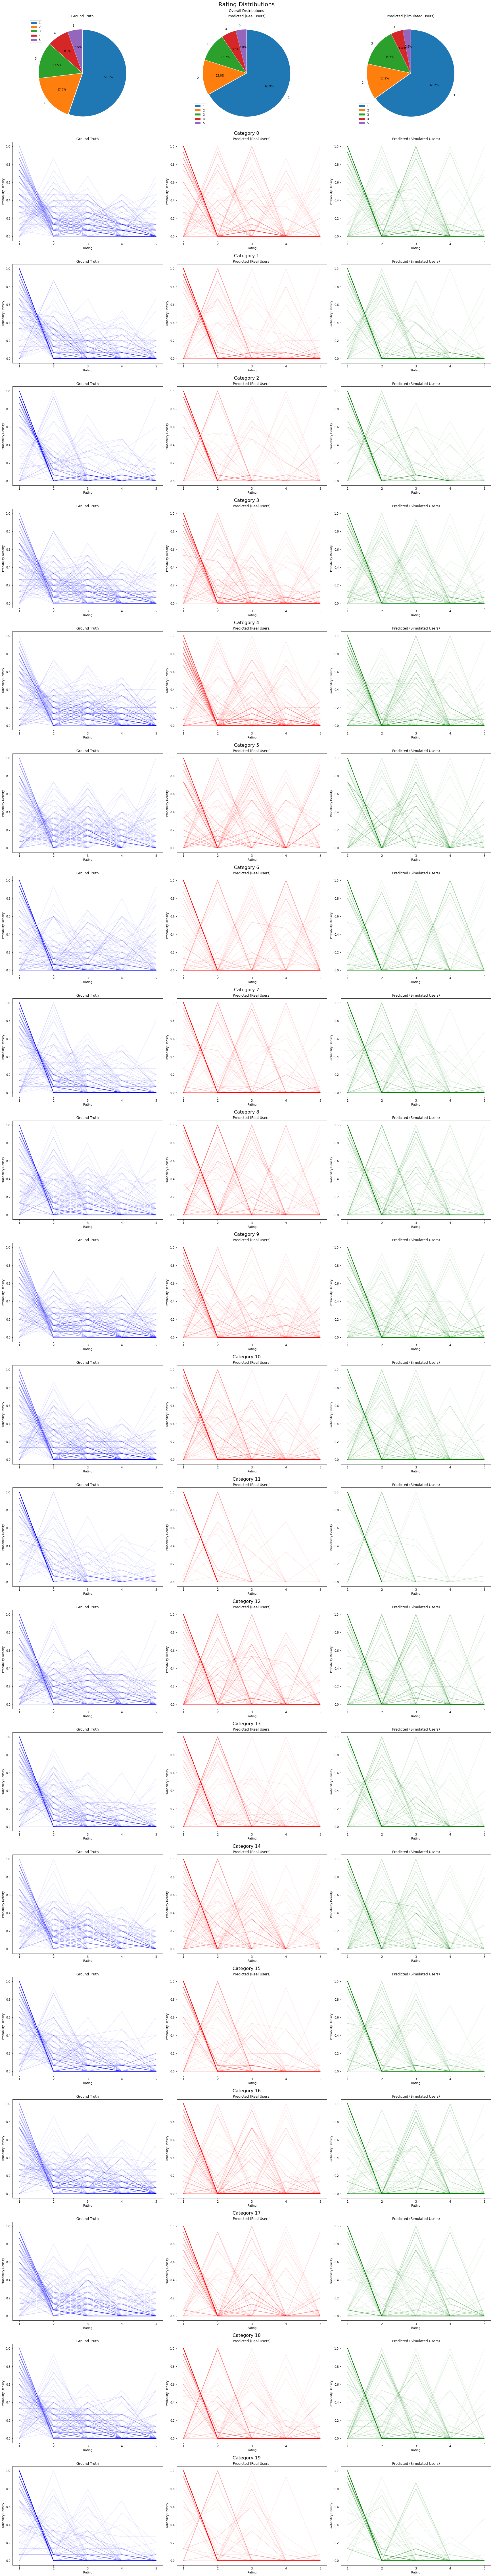

In [8]:
if __name__ == "__main__":
    epochs = 100

    if not os.path.isdir(checkpoints_dir):
        os.makedirs(checkpoints_dir)
    
    
    try:
        tf.get_logger().setLevel("ERROR")

        params = {
            "verbose": 0,
            "shuffle": True,
            "epochs": epochs
        }


        display(HTML("<h2>HyperTuning</h2>"))
        tuner.search(
            X_train,
            Y_train,
            **params,
            validation_split=0.2,
            callbacks=[tensorboard_callback, tools.Printer(), tools.ModelDisplayer(), EarlyStopping(monitor='val_loss', mode="min", patience=5)]
        )


        display(HTML("<h2>Found Optimal Model!</h2>"))
        num_trials = 1

        tuner.results_summary(num_trials=num_trials)
        print("\n")
        best_hps=tuner.get_best_hyperparameters(num_trials=num_trials)[0]

        model = tuner.hypermodel.build(best_hps)
        batch_size = best_hps.Int('batch_size', 32, 256, step=32)
        
        # model = create_model()
        # batch_size = 32

        model.summary()

        model.fit(
            X_train,
            Y_train,
            **params,
            batch_size=batch_size,
            validation_data=(X_test,Y_test),
            callbacks=[tensorboard_callback, checkpoint, tools.ModelDisplayer(), tools.Printer(), d:=DistributionPlotter(), EarlyStopping(monitor='val_loss', mode="min", patience=10)]
        )

        d.plot_now()

    except KeyboardInterrupt:
        pass